## Linear Regression

## Extract code test data

### 2.1 Feature Normalization

In [1]:
import numpy as np
def feature_normalization(train, test):
    # Record the maximun value of each instance in train
    def dis2min(row):
        return row-min(row)
    dis2min_train=np.apply_along_axis(dis2min,axis=1,arr=train)
    instances_max = np.apply_along_axis(max,axis=1,arr=dis2min_train)
    # Calculate 1/max and convert it into a diagonal matrix
    multiplier = np.diag(1/instances_max)
    dis2min_test=np.apply_along_axis(dis2min,axis=1,arr=test)
    return np.dot(multiplier,dis2min_train),np.dot(multiplier,dis2min_test)

In [2]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
print('loading the dataset')
    
df = pd.read_csv('./hw1-sgd/hw1-data.csv', delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

print('Split into Train and Test')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

print("Scaling all to [0, 1]")
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


In [3]:
x_check = np.array([[1,2,3],[4,5,6]])
theta_check = np.array([1,1,1])
y_check = np.array([7,16])

In [4]:
theta = np.ones(X_train.shape[1]) #Initialized theta

### 2.2 Gradient Decent Setup

1) $J(\theta) = \frac{1}{2m}(x \theta - y)^{T}(x \theta - y)$

2) $\triangledown$$J(\theta) = \frac{1}{m} (x \theta - y)^{T} \frac{\partial (x \theta - y)}{\partial \theta} = \frac{1}{m} (x \theta - y)^T x$

3) Using first order approximation, we have: $J(\theta + \eta \Delta) \approx J(\theta) + \triangledown J(\theta)^{T} \eta \Delta$

4) We want $\theta$ to move toward negative gradient direction. Hence the updated $\theta '= \theta - \eta \triangledown J(\theta)$

5) The following shows the code for compute_squre_loss:

In [5]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)
    
    Returns:
        loss - the square loss, scalar
    """
    num_instances = X.shape[0]
    predictions = np.dot(X,theta)
    differences = predictions-y
    loss = 0.5/(num_instances)*np.dot(differences,differences)
    return loss

In [6]:
compute_square_loss(X_train,y_train,theta)

376.13377330782214

6) The following shows the code for compute_square_loss_gradient:

In [9]:
def compute_square_loss_gradient(X, y, theta):
    """
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
    
    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    num_instances = X.shape[0]
    ones = np.ones(num_instances).reshape(num_instances,1)
    #extended_X = np.append(X,ones,axis = 1)
    differences = np.dot(X,theta)-y
    grad = 1.0/num_instances*(np.dot(differences,X))
    return grad   

### 2.3 Gradient Checker

In [10]:
###########################################
### Gradient Checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm.  Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4): 
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions: 
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1) 

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by: 
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error
    
    Return:
        A boolean value indicate whether the gradient is correct or not

    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    for feature_pos in range(num_features):
        e_i = np.zeros(num_features)
        e_i[feature_pos]=1
        theta_plus = theta + epsilon*e_i
        theta_minus = theta - epsilon*e_i 
        approx_grad[feature_pos]=(compute_square_loss(X,y,theta_plus)-compute_square_loss(X,y,theta_minus))/(2*epsilon)
        distance = np.linalg.norm(approx_grad-true_gradient)
    return distance<tolerance

In [11]:
grad_checker(X_train,y_train,theta)

True

In [12]:
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned
    the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient = gradient_func(X,y,theta)
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features)
    for feature_pos in range(num_features):
        e_i = np.zeros(num_features)
        e_i[feature_pos]=1
        theta_plus = theta + epsilon*e_i
        theta_minus = theta - epsilon*e_i 
        approx_grad[feature_pos]=(ojective_func(X,y,theta_plus)-objective_func(X,y,theta_minus))/(2*epsilon)
        distance = np.linalg.norm(approx_grad-true_gradient)
    return distance<tolerance

### 2.4 Batch Gradient Descent

In [14]:
def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False):
    """
    In this question you will implement batch gradient descent to
    minimize the square loss objective
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        num_iter - number of iterations to run 
        check_gradient - a boolean value indicating whether checking the gradient when updating
        
    Returns:
        theta_hist - store the the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features) 
                    for instance, theta in iteration 0 should be theta_hist[0], theta in ieration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1) 
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.ones(num_features) #initialize theta
    for i in range(num_iter+1):
        if i == 0:
            # Record initial loss before gradient descend
            loss_hist[i] = compute_square_loss(X,y,theta)
            theta_hist[i,] = theta
        grad = compute_square_loss_gradient(X,y,theta)
        if check_gradient:
            # Module for gradient diverge debugging
            if grad_checker(X,y,theta)==False:
                print("Alpha:",alpha)
                print("Gradient Fail! at step",i)
                break
        theta = theta-alpha*grad.T
        loss_hist[i] = compute_square_loss(X,y,theta)
        theta_hist[i,] = theta
    return loss_hist,theta_hist

#### 2)

In [15]:
loss_hist_0_01, theta_hist_0_01 = batch_grad_descent(X_train,y_train,alpha=0.01,check_gradient=True)
loss_hist_0_05, theta_hist_0_05 = batch_grad_descent(X_train,y_train,alpha=0.05,check_gradient=True)
loss_hist_0_1, theta_hist_0_1 = batch_grad_descent(X_train,y_train,alpha=0.1,check_gradient=True)
loss_hist_0_5, theta_hist_0_5 = batch_grad_descent(X_train,y_train,alpha=0.5,check_gradient=True)

Alpha: 0.5
Gradient Fail! at step 4


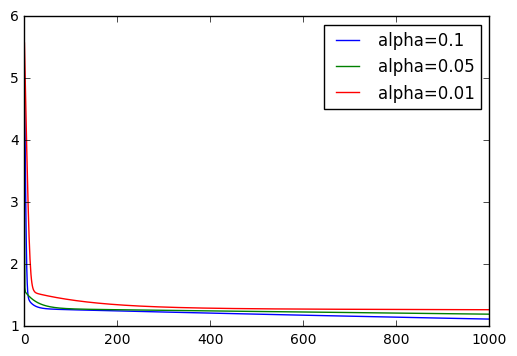

In [16]:
import matplotlib.pyplot as plt
#plt.plot(range(len(loss_hist_0_5)),loss_hist_0_5,label="alpha=0.5")
plt.plot(range(len(loss_hist_0_1)),np.log(loss_hist_0_1),label="alpha=0.1")
plt.plot(range(len(loss_hist_0_05)),np.log(loss_hist_0_05),label="alpha=0.05")
plt.plot(range(len(loss_hist_0_01)),np.log(loss_hist_0_01),label="alpha=0.01")
plt.legend(loc = 1)
plt.show()

We can observe that the larger the steps the faster the objective function value decreases. When alpha= 0.5 the gradient diverge after step 4.

### 2.5 Ridge Regression

1) 1) $\triangledown J(\theta)=\frac{1}{m} (x\theta-y)^{T}\frac{\partial(x\theta-y)}{\partial \theta}+\frac{\partial \lambda \theta^T \theta}{\partial \theta}=\frac{1}{m} (x\theta-y)^{T}x+2\lambda\theta^{T}$ 

2) The following shows the codes for compute_regularized_square_loss_gradient

In [17]:
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized square loss function given X, y and theta
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient
    
    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    square_loss_gradient = compute_square_loss_gradient(X,y,theta)
    regularization_gradient = 2*lambda_reg*theta
    return square_loss_gradient+regularization_gradient

3) The following shows the codes for regularized_grad_descent

In [18]:
def regularized_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        numIter - number of iterations to run 
        
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features) 
        loss_hist - the history of regularized loss value, 1D numpy array
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.ones(num_features) #initialize theta
    for i in range(num_iter+1):
        if i == 0:
            # Record initial loss before gradient descend
            loss_hist[i] = compute_square_loss(X,y,theta)
            theta_hist[i,] = theta
        grad = compute_regularized_square_loss_gradient(X,y,theta,lambda_reg)
        theta = theta-alpha*grad.T
        loss_hist[i] = compute_square_loss(X,y,theta)
        theta_hist[i,] = theta
    return loss_hist,theta_hist

4) Because the bias term is the product of B and the last theta term which is being adjusted. For large B the magnitude of theta adjusting is small and the regularization terms of bias is small compared to the entire regularization.

7)  

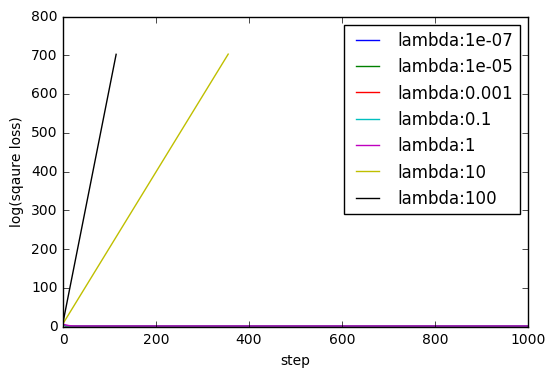

In [19]:
for lambda_reg in [1e-7,1e-5,1e-3,1e-1,1,10,100]:
    loss_hist,theta_hist= regularized_grad_descent(X_train,y_train,lambda_reg=lambda_reg)
    plt.plot(range(len(loss_hist)),np.log(loss_hist),label='lambda:'+str(lambda_reg))
    plt.xlabel("step")
plt.ylabel("log(sqaure loss)")
plt.legend()
plt.show()

It shows that when lambda = 10 and 100, the gradients diverges.

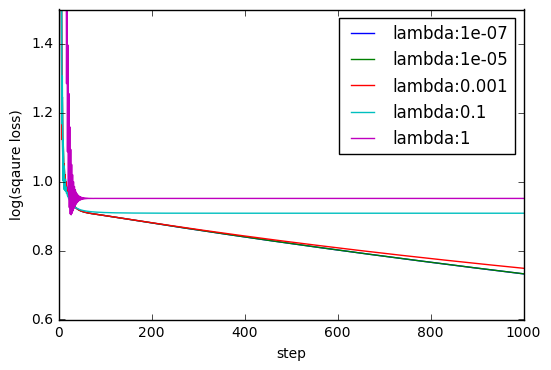

In [20]:
for lambda_reg in [10e-8,10e-6,10e-4,10e-2,1]:
    loss_hist,theta_hist= regularized_grad_descent(X_train,y_train,lambda_reg=lambda_reg)
    loss_hist_test= [compute_square_loss(X_test,y_test,theta) for theta in theta_hist]
    plt.plot(range(len(loss_hist)),np.log(loss_hist_test),label='lambda:'+str(lambda_reg))
plt.xlabel("step")
plt.ylabel("log(sqaure loss)")
plt.ylim(0.6,1.5)
plt.legend(loc=1)
plt.show()

8) I will choose $\theta$ at the last step of regularized gradient descent with $\lambda=10^{-5}$ Since it achives best test set loss.

### 2.6 Stochastic Gradient Descend

1) The update rule of SGD is similar to that of batch gradient descent. Except for SGD, we use partial training data to calculate gradient. The update rule of SGD is:

1. Initialized all parameters $\theta$ 
2. $\theta'=\theta-\eta\triangledown J(\theta)$ where $J(\theta)$ is calculated with a random subset of training set.

2) The following shows the codes of stochastic_grad_descent:

In [32]:
def stochastic_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    In this question you will implement stochastic gradient descent with a regularization term
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float. step size in gradient descent
                NOTE: In SGD, it's not always a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every iteration is alpha.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t)
                if alpha == "1/t", alpha = 1/t
        lambda_reg - the regularization coefficient
        num_iter - number of epochs (i.e number of times) to go through the whole training set
    
    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features) 
        loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter+1, num_instances)) #Initialize loss_hist
    for i in range(num_iter+1):
        if i == 0:
            # Record initial loss before gradient descend
            loss_hist[i] = compute_square_loss(X,y,theta)
            theta_hist[i,] = theta
        if alpha=='1/sqrt(t)':
            alpha = 1.0/np.sqrt(i)
        if alpha=='1/t':
            alpha== 1.0/i
        #Splitting the entire sets into two batchs, which is name _train _test
        #The nameing is a little bit nasty so that I can copy and paste former codes
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.5, random_state=10)
        X_train, X_test = feature_normalization(X_train, X_test)
        #X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
        #X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term
        grad = compute_regularized_square_loss_gradient(X_train,y_train,theta,lambda_reg)
        theta = theta-alpha*grad.T
        grad = compute_regularized_square_loss_gradient(X_test,y_test,theta,lambda_reg)
        theta = theta-alpha*grad.T
        loss_hist[i] = compute_square_loss(X,y,theta)
        theta_hist[i,] = theta
    return loss_hist,theta_hist

In [33]:
#debug session


3)

#### Fix steps

In [34]:
for step_size in [0.05,0.005]:
    loss_hist_SGD,theta_hist_SGD = stochastic_grad_descent(X_train,y_train,lambda_reg=1e-5,alpha=step_size)
    print(loss_hist_SGD)
    #plt.plot(range(len(loss_hist_SGD)),np.log(loss_hist_SGD),label='lambda:'+str(step_size))
#plt.xlabel("step")
#plt.ylabel("log(sqaure loss)")
#plt.legend()
#plt.show()

[[ 5.16799016  5.16799016  5.16799016 ...,  5.16799016  5.16799016
   5.16799016]
 [ 4.7001379   4.7001379   4.7001379  ...,  4.7001379   4.7001379
   4.7001379 ]
 [ 4.61285467  4.61285467  4.61285467 ...,  4.61285467  4.61285467
   4.61285467]
 ..., 
 [ 3.06196527  3.06196527  3.06196527 ...,  3.06196527  3.06196527
   3.06196527]
 [ 3.06150429  3.06150429  3.06150429 ...,  3.06150429  3.06150429
   3.06150429]
 [ 3.06104347  3.06104347  3.06104347 ...,  3.06104347  3.06104347
   3.06104347]]
[[ 267.30881473  267.30881473  267.30881473 ...,  267.30881473
   267.30881473  267.30881473]
 [ 190.38070423  190.38070423  190.38070423 ...,  190.38070423
   190.38070423  190.38070423]
 [ 135.99910172  135.99910172  135.99910172 ...,  135.99910172
   135.99910172  135.99910172]
 ..., 
 [   3.55976513    3.55976513    3.55976513 ...,    3.55976513
     3.55976513    3.55976513]
 [   3.55969398    3.55969398    3.55969398 ...,    3.55969398
     3.55969398    3.55969398]
 [   3.55962286    3.559

## Risk Estimation
### 3.1 Square Loss
#### 1

Since $f(x) = a$ is a deterministic function. We must have $\mathbf{E}[a] = a$ and $Var(a) = 0$.
For any random variable $X$, we must have $Var(X)=\mathbf{E}[x^2] - \mathbf{E}[x]^2$, then $\mathbf{E}[x^2] = Var(x) + \mathbf{E}[x]^2$ 

Then we have:
$$
\begin{split}
\mathbf{E}[(a-y)^2] &= \mathbf{E}[a^2 - 2ay + y^2] \\
&= \mathbf{E}[a^2] +\mathbf{E}[y^2] - \mathbf{E}[2ay]\\
&= Var(a) + Var(y) +\mathbf{E}[a]^2 + \mathbf{E}[y]^2 - 2a\mathbf{E}[y]\\
&= Var(y) + (a - \mathbf{E}[y])^2
\end{split}
$$


We can see that $E[(a-y)^2]$ reaches minimun when $a=\mathbf{E}[y]$ with Bayes risk of $Var(y)$

2) Similar to part 1 , we have $\mathbf{E}[a|x] = a$ and $Var(a|x) = 0$ since a is a deterministic function of x.

We have $\mathbf{E}[(a-y)^2|x]=Var(y|x)+(a-\mathbf{E}[y|x])^2$. With $Var(y|x)$ being independent of $x$, we should predict $a = \mathbf{E}[y|x])$

3) $\mathbf{E}[(a-y)^2]=\mathbf{E}[\mathbf{E}[(a-y)^2|x]]=\mathbf{E}[Var(y|x)]+\mathbf{E}[(a-\mathbf{E}[y|x])^2]$
The first term is independent of a, since all $(a-\mathbf{E}[y])^2$ must be greater than zero, the minimun of $\mathbf{E}[(a-\mathbf{E}[y|x])^2]$ must be 0. And when $a=\mathbf{E}[y|x]$, the second term is zero which is the minimun value.